This problem is comprised of 768 observations of medical details for Pima indians patents. The records describe instantaneous measurements taken from the patient such as their age, the number of times pregnant and blood workup. All patients are women aged 21 or older. All attributes are numeric, and their units vary from attribute to attribute.

Each record has a class value that indicates whether the patient suffered an onset of diabetes within 5 years of when the measurements were taken (1) or not (0).

This is a standard dataset that has been studied a lot in machine learning literature. A good prediction accuracy is 70%-76%.

Source: https://www.kaggle.com/uciml/pima-indians-diabetes-database

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#Read in our raw data
raw = pd.read_csv('C:/Users/LianJ/Desktop/pima-indians-diabetes.csv', header = None)

In [3]:
#Checking data types
raw.dtypes

0      int64
1      int64
2      int64
3      int64
4      int64
5    float64
6    float64
7      int64
8      int64
dtype: object

In [4]:
raw.shape #768 records in 9 columns

(768, 9)

In [5]:
raw.isnull().sum() #Checking missing values for columns

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64

In [6]:
#Separate X and y
X = raw[raw.columns[0:8]]
y = raw[raw.columns[8]]

In [7]:
#Now we randomly split our train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [8]:
#Fit our model using Gaussian naive bayes classifiers
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb_fit = gnb.fit(X_train, y_train)

In [9]:
#Fit the test set
y_pred = gnb_fit.predict(X_test)

In [10]:
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0],(y_test != y_pred).sum()))

Number of mislabeled points out of a total 254 points : 67


In [11]:
#Now we try to standardize the dataset
from sklearn.preprocessing import StandardScaler

X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

In [12]:
#Standardized prediction not nessecariliy doing well compared to non-standardized predictions
gnb_fit_scaled = gnb.fit(X_train_scaled, y_train)
y_pred_scaled = gnb_fit_scaled.predict(X_test_scaled)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0],(y_test != y_pred_scaled).sum()))

Number of mislabeled points out of a total 254 points : 68


In [13]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

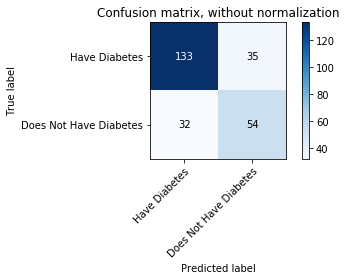

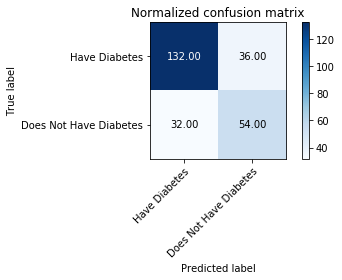

In [16]:
class_names = (['Have Diabetes', 'Does Not Have Diabetes'])
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

plot_confusion_matrix(y_test, y_pred_scaled, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

So the previous method using Navie Bayes reached roughly about 73.6% accuracy

In [17]:
#Now trying stochastic gradient descent using scaled data, and grid search to find the best model
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "none", "elasticnet"],
}

model = SGDClassifier(max_iter=1000)
clf = GridSearchCV(model, param_grid=params)

In [18]:
clf.fit(X_train_scaled, y_train)
print(clf.best_score_)

0.7840466926070039


In [19]:
print(clf.best_estimator_)

SGDClassifier(alpha=0.01, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)


In [20]:
y_sgd_pred = clf.predict(X_test_scaled)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0],(y_test != y_sgd_pred).sum()))

Number of mislabeled points out of a total 254 points : 63


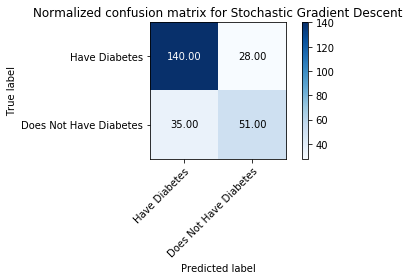

In [21]:
#Check the confusion matrix
plot_confusion_matrix(y_test, y_sgd_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for Stochastic Gradient Descent')

Now the SGD Classifier reached roughly about 75.2% Accuracy

In [22]:
#Now trying linear SVM to see how this model perform in our dataset
from sklearn.svm import LinearSVC
params = {
    "loss" : ["hinge", "squared_hinge"],
    "C" : [0.1, 1, 10, 100],
}

model = LinearSVC()
clf = GridSearchCV(model, param_grid=params)

In [23]:
clf.fit(X_train_scaled, y_train)
print(clf.best_score_)

0.7762645914396887


In [24]:
print(clf.best_estimator_)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)


In [25]:
y_svm_pred = clf.predict(X_test_scaled)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0],(y_test != y_svm_pred).sum()))

Number of mislabeled points out of a total 254 points : 62


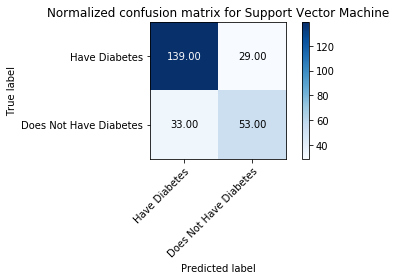

In [26]:
#Check the confusion matrix
plot_confusion_matrix(y_test, y_svm_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for Support Vector Machine')

Now the Linear SGD Classifier reached roughly about 75.6% Accuracy, slightly better than SGD and better than Naive Bayes

In [27]:
from sklearn.svm import SVC
params = {
    "degree" : [3, 5, 10],
    "coef0" : [0.1, 1, 10],
    "C" : [0.1, 1, 10],
}

poly_model = SVC(kernel = "poly")
poly_clf = GridSearchCV(poly_model, param_grid=params)

In [28]:
poly_clf.fit(X_train_scaled, y_train)
print(poly_clf.best_score_)

0.7704280155642024


In [29]:
y_poly_pred = poly_clf.predict(X_test_scaled)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0],(y_test != y_poly_pred).sum()))

Number of mislabeled points out of a total 254 points : 61


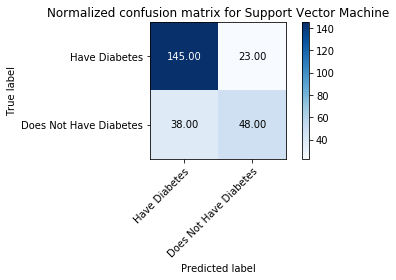

In [30]:
#Check the confusion matrix
plot_confusion_matrix(y_test, y_poly_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for Support Vector Machine')

Up to now, polynomial SVM does the best job in accuracy has 76% accuracy

In [31]:
#Lastly we try the randomforest classifier
from sklearn.ensemble import RandomForestClassifier

rnf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=8, n_jobs=-1)
rnf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=8,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [32]:
y_rnf_pred = rnf_clf.predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0],(y_test != y_rnf_pred).sum()))

Number of mislabeled points out of a total 254 points : 58


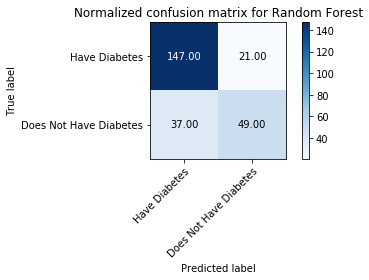

In [33]:
#Check the confusion matrix
plot_confusion_matrix(y_test, y_rnf_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for Random Forest')

Although our accuracy keeps increasing regarding the model we use, there are benefits of different algorithms that we use
for example, the naive bayes does the best in make mistakes for patient that actually does not have diabetes as have diabetes.
It really depends on the problem we are trying to tackle. 